In [1]:
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
batch_size = 20
embedding_size = 2
num_sampled = 1

sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]

words = " ".join(sentences).split()
count = collections.Counter(words).most_common()
print ("Word count", count[:5])

rdic = [i[0] for i in count] #reverse dic, idx -> word
dic = {w: i for i, w in enumerate(rdic)} #dic, word -> id
voc_size = len(dic)

data = [dic[word] for word in words]
print('Sample data', data[:10], [rdic[t] for t in data[:10]])

cbow_pairs = [];
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
print('Context pairs', cbow_pairs[:10])

skip_gram_pairs = [];
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
print('skip-gram pairs', skip_gram_pairs[:5])


def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data=[]
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

print ('Batches (x, y)', generate_batch(3))

('Word count', [('cats', 10), ('dogs', 6), ('and', 5), ('are', 4), ('love', 3)])
('Sample data', [8, 33, 24, 20, 17, 12, 8, 25, 30, 26], ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'I'])
('Context pairs', [[[8, 24], 33], [[33, 20], 24], [[24, 17], 20], [[20, 12], 17], [[17, 8], 12], [[12, 25], 8], [[8, 30], 25], [[25, 26], 30], [[30, 4], 26], [[26, 0], 4]])
('skip-gram pairs', [[33, 8], [33, 24], [24, 33], [24, 20], [20, 24]])
('Batches (x, y)', ([20, 30, 4], [[24], [26], [26]]))


In [6]:
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])

train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

with tf.device('/cpu:0'):
    embeddings = tf.Variable(
        tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

loss = tf.reduce_mean(
  tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

('Loss at ', 0, 2.2570062)
('Loss at ', 10, 5.0694456)
('Loss at ', 20, 3.3777153)
('Loss at ', 30, 2.3767183)
('Loss at ', 40, 2.4187427)
('Loss at ', 50, 7.5550132)
('Loss at ', 60, 4.8413815)
('Loss at ', 70, 1.1108326)
('Loss at ', 80, 2.48317)
('Loss at ', 90, 3.8359687)


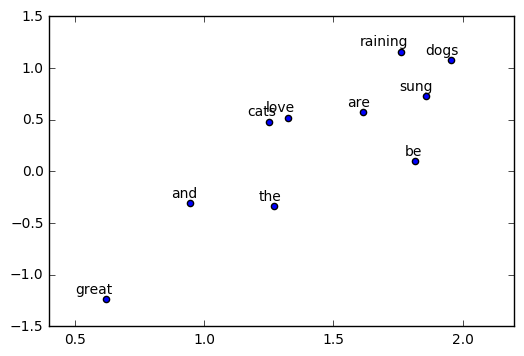

In [7]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    for step in range(100):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        if step % 10 == 0:
          print("Loss at ", step, loss_val) # Report the loss

    trained_embeddings = embeddings.eval()

    
if trained_embeddings.shape[1] == 2:
    labels = rdic[:10]
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    plt.savefig("word2vec.png")